In [1]:
#Reframing SigKernel
import apache_beam

In [2]:
import os
import weatherbench2
import xarray as xr
import math
from weatherbench2.regions import SliceRegion, ExtraTropicalRegion
from weatherbench2.evaluation import evaluate_in_memory
from weatherbench2 import config
import numpy as np
import sigkernel
import torch
from einops import rearrange
from itertools import product
import cython
import matplotlib.pyplot  as plt
import tqdm

In [3]:
forecast_path = 'gs://weatherbench2/datasets/ifs_ens/2018-2022-64x32_equiangular_conservative.zarr'
obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-64x32_equiangular_conservative.zarr'
forecasts = xr.open_zarr(forecast_path)
observations = xr.open_zarr(obs_path)

In [4]:
forecastssel = forecasts['temperature'].sel(level = 500, time = slice('2020-01-01', '2020-01-25'))
forecasts0 = forecastssel[:,:,:,:,:]
savedfor = forecasts0.values

observationsel = observations['temperature'].sel(level = 500, time = slice('2020-01-01', '2020-01-25')) #Same time?
savedobs = observationsel.values
#1 month forecasts (1.5 obs) takes 1m9

In [24]:
def findscale(obs,fors):
    maxvalue = np.array([obs.max(),fors.max()]).max()
    #days = obs[::4].shape[0]

    return maxvalue#*days


In [143]:
forecasts0[0,0,0:0+4,0,0]
forecasts0

math.floor(forecasts0.shape[0]- 0.5*3)
k=3
observationsel[0:3,:,:]
observationsel[2:5,:,:]
savedfor.shape

sigkernel.normalize(savedfor)

TypeError: normalize() missing 2 required positional arguments: 'width' and 'depth'

In [47]:
def pk(observations,forcasts,sigma,k):

    #Ensure K is reasonalbe, not negative, integer only, not outside bounds >2
        max = findscale(observations, forcasts)
        static_kernel = sigkernel.Linear_ID_Kernel()  #RBFKernel(sigma=sigma)
        dyadic_order = 2
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
        time = forcasts.shape[0]
        count = 0
        sum = 0
        #think about removing culmative
        for i in range(math.floor(time- 0.5*k)): #20
                #Think about code...
                #Something about forecasts/observations lag lining up
                fors = forcasts[i,:,0:k+1,:,:]
                obs = observations[2*i:2*i+k+1,:,:]

                fors = fors.reshape(50,k+1,64*32)
                obs = obs.reshape(-1,64*32)

                obs = np.expand_dims(obs, axis = 0)
                
                scale = max
                llobs = sigkernel.transform(obs, scale = 1/scale, at = True, ll = False)
                #print(llobs)
                llfors = sigkernel.transform(fors, scale = 1/scale, at = True, ll = False)

                X = torch.tensor(llfors, dtype=torch.double)
                y = torch.tensor(llobs, dtype=torch.double)
                #print(X.shape)
                #print(y.shape)

                #K_XX = signature_kernel.compute_Gram(X, X, sym=True, max_batch=100)
                #K_Xy = signature_kernel.compute_Gram(X, y, sym=False, max_batch=100)

                #K_XX_m = (torch.sum(K_XX) - torch.sum(torch.diag(K_XX))) / (K_XX.shape[0] * (K_XX.shape[0] - 1.))

                #print(K_XX_m)
                #print(-2*torch.mean(K_Xy))

                val = signature_kernel.compute_scoring_rule(X,y).item()
                #print(val)
                sum = sum +val
                count +=1
                #print(sum/count)
        return (sum/count)

In [197]:
vals =[None]*10
for k in range(10):
    vals[k] = pk(savedobs,savedfor,3,k+1)
#Do a trial run

[[[  0.         238.73791504 240.69900513 ... 235.79962158 231.67601013
   231.53475952]
  [  1.         238.87072754 241.12475586 ... 235.87728882 231.69233704
   230.24873352]]]
[[[  0.         238.7802124  241.11141968 ... 236.59318542 231.80360413
   230.08340454]
  [  1.         238.41146851 241.27334595 ... 237.04827881 232.36238098
   230.18104553]]]
[[[  0.         238.50765991 241.29719543 ... 237.23951721 233.53988647
   230.57644653]
  [  1.         238.69613647 241.07196045 ... 237.4644165  234.36628723
   231.65541077]]]
[[[  0.         239.25524902 240.89079285 ... 236.88117981 234.56204224
   232.87013245]
  [  1.         239.57873535 240.75640869 ... 236.95567322 234.33784485
   233.21670532]]]
[[[  0.         240.0975647  240.47247314 ... 235.81251526 233.83448792
   233.32064819]
  [  1.         239.98925781 240.17575073 ... 234.92889404 233.28862
   233.69380188]]]
[[[  0.         239.78999329 239.84843445 ... 234.69447327 233.40615845
   233.9433136 ]
  [  1.       

KeyboardInterrupt: 

In [49]:
vals =[None]*20
for k in range(20):
    vals[k] = pk(savedobs,savedfor,"empty",k+1)
    print(vals[k])

-2.334838811325926
-2.453460041757613
-2.5963452462455057
-2.740337829758552
-2.8837008680148912
-3.0125276769249454
-3.132151822217049
-3.232305666773953
-3.327850956615306
-3.40557300019383
-3.479487496560107
-3.5396049790999267
-3.605123382396529
-3.6602455549591824
-3.7210489417562194
-3.7709481506280236
-3.8304231798239514
-3.8781437084818426
-3.931031130903326
-3.9689222167782363


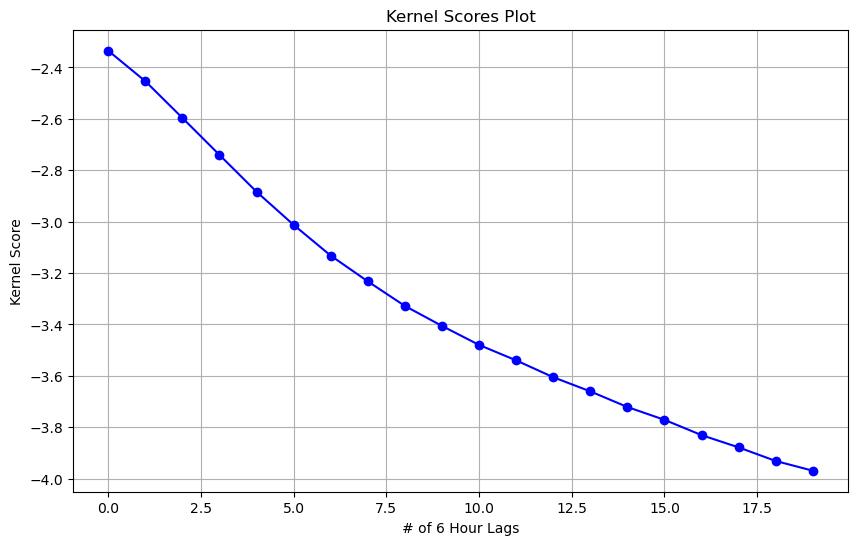

In [50]:
#Using sigma, and global maxvalue, 20
plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(vals, marker='o', linestyle='-', color='b')  # Plot with line and marker
plt.title("Kernel Scores Plot")
plt.xlabel("# of 6 Hour Lags")
plt.ylabel("Kernel Score")
plt.grid(True)  # Optional: add a grid for better readability
plt.show()

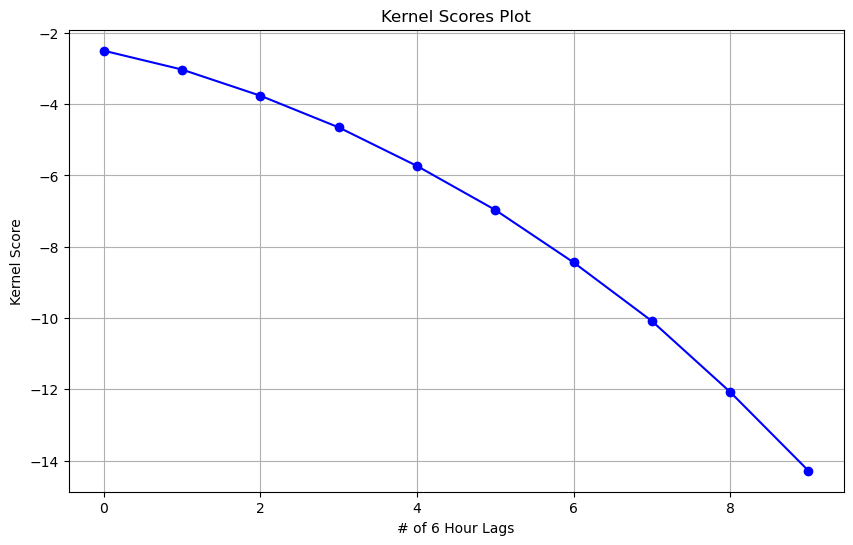

In [46]:
#Using sigma, and global maxvalue/2
plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(vals, marker='o', linestyle='-', color='b')  # Plot with line and marker
plt.title("Kernel Scores Plot")
plt.xlabel("# of 6 Hour Lags")
plt.ylabel("Kernel Score")
plt.grid(True)  # Optional: add a grid for better readability
plt.show()

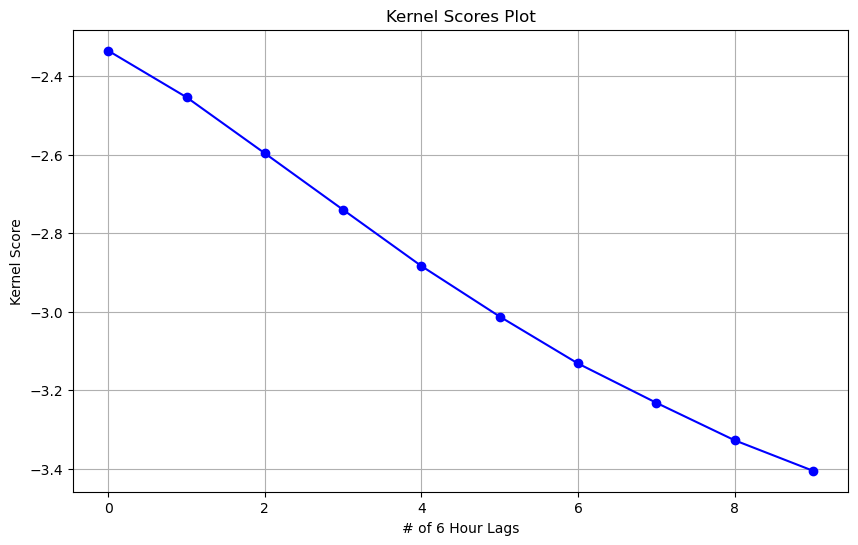

In [ ]:
#Using sigma, and global maxvalue 
plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(vals, marker='o', linestyle='-', color='b')  # Plot with line and marker
plt.title("Kernel Scores Plot")
plt.xlabel("# of 6 Hour Lags")
plt.ylabel("Kernel Score")
plt.grid(True)  # Optional: add a grid for better readability
plt.show()

In [40]:
pk(savedobs,savedfor,2,3)

-2.5963452462455057

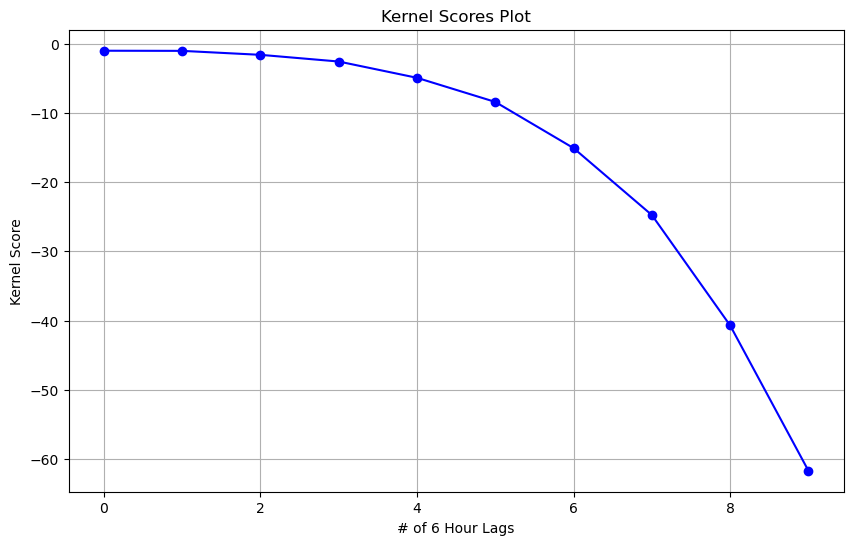

In [ ]:
#Using sigma, and particular maxvalue 
plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(vals, marker='o', linestyle='-', color='b')  # Plot with line and marker
plt.title("Kernel Scores Plot")
plt.xlabel("# of 6 Hour Lags")
plt.ylabel("Kernel Score")
plt.grid(True)  # Optional: add a grid for better readability
plt.show()

In [101]:
def pktest(observations,forcasts,sigma,k):

    #Ensure K is reasonalbe, not negative, integer only, not outside bounds >2
        scale = findscale(observations, forcasts)/200
        static_kernel = sigkernel.RBFKernel(sigma=sigma)
        dyadic_order = 2
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
        time = forcasts.shape[0]
        count = 0
        #think about removing culmative
        i = 0
        fors = forcasts[i,:,0:k+1,:,:]
        obs = observations[2*i:2*i+k+1,:,:]

        fors = fors.reshape(50,k+1,64*32)
        obs = obs.reshape(-1,64*32)

        obs = np.expand_dims(obs, axis = 0)

        llobs = sigkernel.transform(obs, scale = 1/scale, at = True, ll = False)
        llfors = sigkernel.transform(fors, scale = 1/scale, at = True, ll = False)
    
        X = torch.tensor(llfors, dtype=torch.double)
        y = torch.tensor(llobs, dtype=torch.double)
        #print(static_kernel.batch_kernel(X,X))
        #print(X)
        #print(X.shape)
        #print(y)
        #print(y.shape)

        val = signature_kernel.compute_scoring_rule(X,y).item()
        print(val)
        count +=1
        return val


In [105]:
#pktest(savedobs,savedfor,2,5)
findscale(savedobs, savedfor)/276
#np.array([savedobs.max(),savedfor.max()]).max()

25.083273735599242

In [13]:
observations = savedobs
forcasts = savedfor
sigma = 2
k = 1
    
#Ensure K is reasonalbe, not negative, integer only, not outside bounds >2
scale = findscale(observations, forcasts)
static_kernel = sigkernel.RBFKernel(sigma=sigma)
dyadic_order = 2
signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
time = forcasts.shape[0]
count = 0
#think about removing culmative
for i in range(math.floor(time- 0.5*k)): #20
        print(i)
        fors = forcasts[i,:,0:k+1,:,:]
        obs = observations[2*i:2*i+k+1,:,:]
        
 
        fors = fors.reshape(50,k+1,64*32)
        obs = obs.reshape(-1,64*32)

        print(fors[0,:,:])

        obs = np.expand_dims(obs, axis = 0)

        llobs = sigkernel.transform(obs, scale = 1/scale, at = False, ll = False)
        llfors = sigkernel.transform(fors, scale = 1/scale, at = False, ll = False)

        X = torch.tensor(llfors, dtype=torch.double)
        y = torch.tensor(llobs, dtype=torch.double)
        print(X.shape)
        print(y.shape)

        val = signature_kernel.compute_scoring_rule(X,y).item()
        print(val)
        count +=1
    


0
[[238.6304  240.68762 241.64917 ... 235.4919  231.97208 231.20317]
 [238.65195 240.98102 241.22441 ... 235.57828 231.69214 230.0284 ]]
torch.Size([50, 2, 2048])
torch.Size([1, 2, 2048])
-1.0000490385708514
1
[[238.60582 240.9989  240.84312 ... 236.53488 231.58055 229.75255]
 [238.28616 241.20024 240.99359 ... 237.28767 232.19566 229.83232]]
torch.Size([50, 2, 2048])
torch.Size([1, 2, 2048])
-1.000042003546376
2
[[238.27295 241.33583 240.73112 ... 237.15143 233.73253 230.50919]
 [238.47806 241.14185 240.77432 ... 237.29198 234.54948 231.6687 ]]
torch.Size([50, 2, 2048])
torch.Size([1, 2, 2048])
-1.0000454792283866
3
[[239.12527 240.93787 240.4648  ... 236.68262 234.4965  232.96138]
 [239.54398 240.78076 240.45673 ... 237.05133 234.54617 233.44754]]
torch.Size([50, 2, 2048])
torch.Size([1, 2, 2048])
-1.0000428484882626
4
[[239.89163 240.45554 239.71698 ... 236.256   234.37486 233.61168]
 [239.77293 240.14294 239.30557 ... 235.42836 233.76836 233.85716]]
torch.Size([50, 2, 2048])
torch.